In [369]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ADFTest
from matplotlib import pyplot
import logging

In [370]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'preprocessing', 'data', 'data.h5')

### Data

In [371]:
dataTrain = pd.read_hdf(data_path, key="train_univariate")
dataVal = pd.read_hdf(data_path, key="validation_univariate")
print("Size of the training set: ", dataTrain.shape)
print("Size of the validation set: ", dataVal.shape)

Size of the training set:  (8764, 186)
Size of the validation set:  (184, 186)


In [372]:
# get columns that have std or mae in their name
std_columns = [col for col in dataTrain.columns if 'std' in col]
mae_columns = [col for col in dataTrain.columns if 'mae' in col]
uncertainty_columns = std_columns + mae_columns;

### Test for stationarity

In [373]:
for col in uncertainty_columns:
    try:
        if ADFTest(alpha=0.05).should_diff(dataTrain[col])[1] == True:
            print("Column {} is not stationary".format(col))
    except BaseException as exception:
        print("Column {} has error: {}".format(col, exception))

Column ens_std-DEU_TEMP_EC15-300 has error: Input contains NaN.
Column ens_std-DEU_TEMP_EC15-360 has error: Input contains NaN.
Column ens_std-DEU_TEMP_EC15-366 has error: Input contains NaN.
Column mae-DEU_TEMP_EC15-300 has error: Input contains NaN.
Column mae-DEU_TEMP_EC15-360 has error: Input contains NaN.
Column mae-DEU_TEMP_EC15-366 has error: Input contains NaN.


### Trying to predict out of sample uncertainty

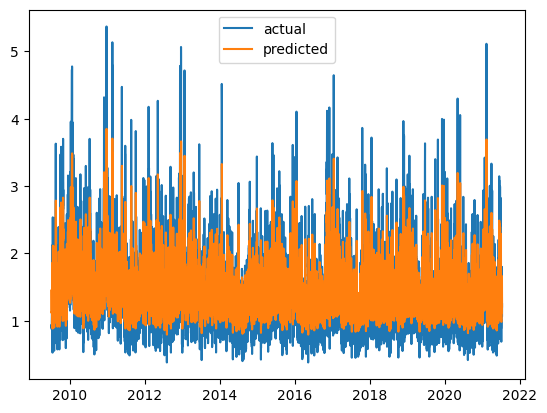

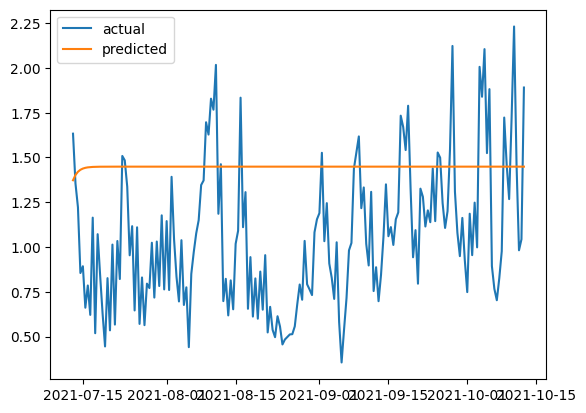

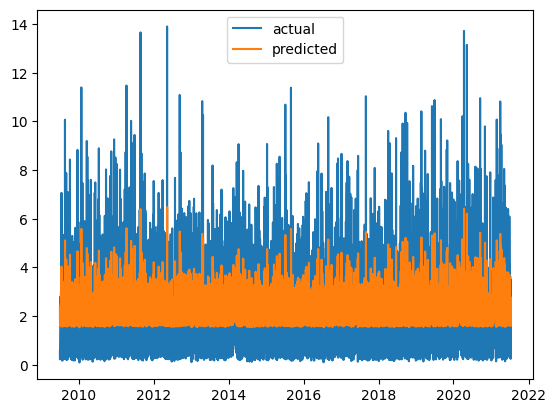

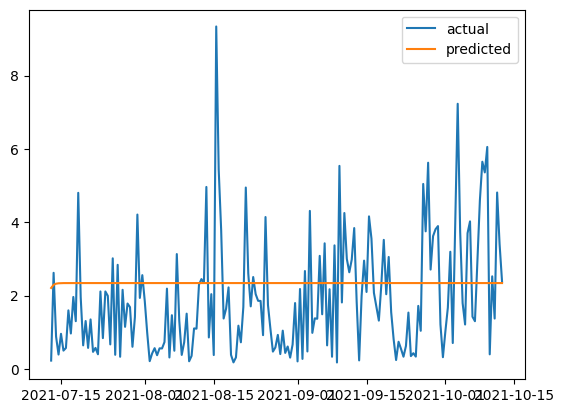

<Figure size 640x480 with 0 Axes>

In [376]:
uncertainty_columns = ['ens_std-DEU_TEMP_EC15-138','mae-DEU_TEMP_EC15-30']
for col in uncertainty_columns:
    model = ARIMA(dataTrain[col], order=(1,0,0))
    model_fit = model.fit()
    model_pred = model_fit.predict(start=np.size(dataTrain,0), end=np.size(dataTrain,0)+np.size(dataVal,0), typ='levels')[1:]
    model_pred.index = dataVal.index

    # plot results for the training set
    pyplot.plot(dataTrain[col], label='actual')
    pyplot.plot(model_fit.fittedvalues, label='predicted')
    pyplot.legend()
    pyplot.show()
    #save the plots
    pyplot.savefig(os.path.join(os.path.dirname(os.getcwd()), 'models', 'plots', 'univariate', 'training', col + '.png'))

    # plot results for the validation set
    pyplot.plot(dataVal[col], label='actual')
    pyplot.plot(model_pred, label='predicted')
    pyplot.legend()
    pyplot.show()
    #save the plots
    pyplot.savefig(os.path.join(os.path.dirname(os.getcwd()), 'models', 'plots', 'univariate', 'validation', col + '.png'))

##### In the validation set, the model converges to the long term mean as expected

### Simply predicting one step ahead

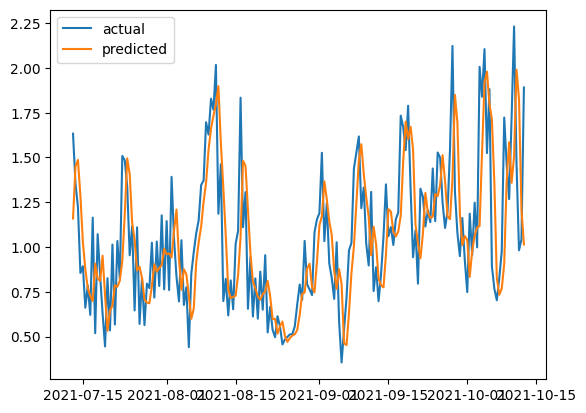

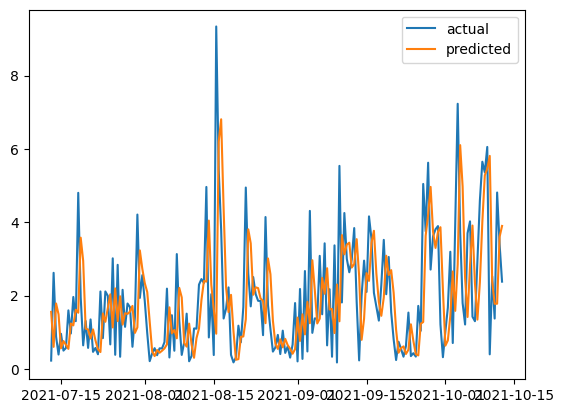

<Figure size 640x480 with 0 Axes>

In [419]:
uncertainty_columns = ['ens_std-DEU_TEMP_EC15-138','mae-DEU_TEMP_EC15-30']
data = dataTrain.append(dataVal)
nTrain = np.size(dataTrain,0)

for col in uncertainty_columns:

    valPred = []
    for t in range(len(dataVal)):
        model = ARIMA(data[col][:nTrain+t], order=(1,1,0))
        model_fit = model.fit()
        yhat = model_fit.forecast()
        valPred.append(float(yhat))
    dataVal[col + '_pred'] = valPred

    # plot results for the validation set
    pyplot.plot(dataVal[col], label='actual')
    pyplot.plot(dataVal[col + '_pred'], label='predicted')
    pyplot.legend()
    pyplot.show()
    #save the plots
    pyplot.savefig(os.path.join(os.path.dirname(os.getcwd()), 'models', 'plots', 'univariate', 'validation', col + '.png'))
    

In [420]:
# calclulate the mean squared error for the validation set
for col in uncertainty_columns:
    mse = np.mean((dataVal[col].values - dataVal[col + '_pred'].values)**2)
    print("The mean squared error for {} is: {}".format(col, mse))

The mean squared error for ens_std-DEU_TEMP_EC15-138 is: 0.09519980217803595
The mean squared error for mae-DEU_TEMP_EC15-30 is: 2.600375978963702


### Predicting one step ahead for all columns

In [421]:
def univariate_uncertainty_prediction(dataTrain, dataVal):
    std_columns = [col for col in dataTrain.columns if 'std' in col]
    mae_columns = [col for col in dataTrain.columns if 'mae' in col]
    uncertainty_columns = std_columns + mae_columns

    data[uncertainty_columns] = dataTrain[uncertainty_columns].append(dataVal[uncertainty_columns])
    nTrain = np.size(dataTrain,0)

    for col in uncertainty_columns:
        valPred = []
        for t in range(len(dataVal)):
            model = ARIMA(data[col][:nTrain+t], order=(1,0,0))
            model_fit = model.fit()
            yhat = model_fit.forecast()
            valPred.append(float(yhat))
        dataVal[col + '_pred'] = valPred
    
    return dataVal

In [422]:
predVal = univariate_uncertainty_prediction(dataTrain, dataVal)

In [424]:
std_columns = [col for col in dataTrain.columns if 'std' in col]
mae_columns = [col for col in dataTrain.columns if 'mae' in col]
uncertainty_columns = std_columns + mae_columns

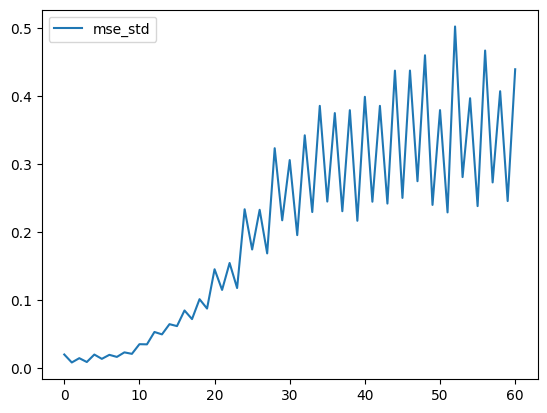

In [430]:
# calclulate the mean squared error for the validation set
mse_std = []
for col in std_columns:
    mse = np.mean((dataVal[col].values - dataVal[col + '_pred'].values)**2)
    mse_std.append(mse)

#plot the results
pyplot.plot(mse_std, label='mse_std')
pyplot.legend()
pyplot.show()

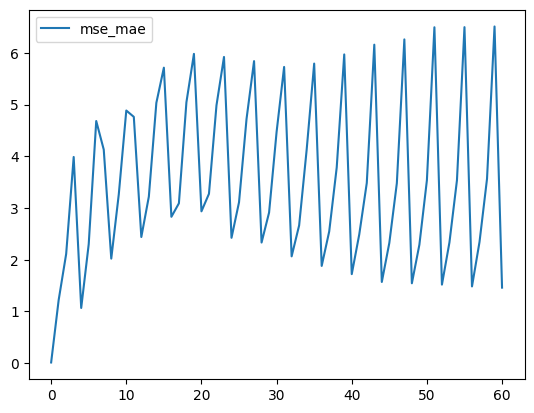

In [431]:
mse_mae = []
for col in mae_columns:
    mse = np.mean((dataVal[col].values - dataVal[col + '_pred'].values)**2)
    mse_mae.append(mse)

#plot the results
pyplot.plot(mse_mae, label='mse_mae')
pyplot.legend()
pyplot.show()

### For specific ValueDate, see ensemble uncertainty vs predicted uncertainty for different ForecastHorizon

#### For Uncertainty measured as STD

In [441]:
predVal_std = dataVal[[col for col in dataVal.columns if 'std' in col and '_pred' in col]]
dataVal_std = dataVal[[col for col in dataVal.columns if 'std' in col and '_pred' not in col]]
std_pred = [predVal_std.iloc[-1,0]]
std_true = [dataVal_std.iloc[-1,0]]
for iter in range(1,int(len(std_columns)/2)):
    row = np.size(dataVal,0) - iter - 1
    col = 2 * iter
    std_pred.append(predVal_std.iloc[row,col])
    std_true.append(dataVal_std.iloc[row,col])

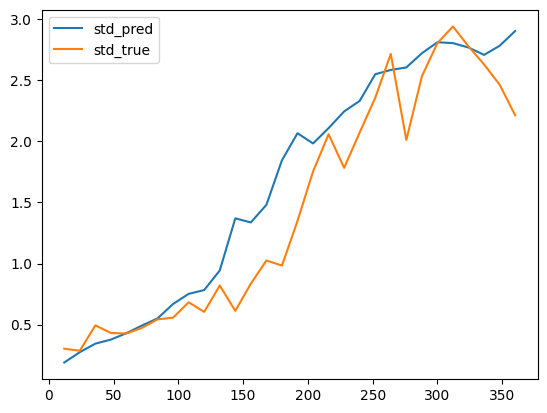

<Figure size 640x480 with 0 Axes>

In [462]:
# plot std_pred vs std_true
x_axis = np.arange(12, 372, 12)
pyplot.plot(x_axis, std_pred[1:], label='std_pred')
pyplot.plot(x_axis, std_true[1:], label='std_true')
pyplot.legend()
pyplot.show()
#save the plots
pyplot.savefig(os.path.join(os.path.dirname(os.getcwd()), 'models', 'plots', 'univariate', 'validation', 'std_pred_vs_std_true.png'))

#### For Uncertainty measured as MAE

In [445]:
predVal_mae = dataVal[[col for col in dataVal.columns if 'mae' in col and '_pred' in col]]
dataVal_mae = dataVal[[col for col in dataVal.columns if 'mae' in col and '_pred' not in col]]
mae_pred = [predVal_mae.iloc[-1,0]]
mae_true = [dataVal_mae.iloc[-1,0]]
for iter in range(1,int(len(std_columns)/2)):
    row = np.size(dataVal,0) - iter - 1
    col = 2 * iter
    mae_pred.append(predVal_std.iloc[row,col])
    mae_true.append(dataVal_std.iloc[row,col])

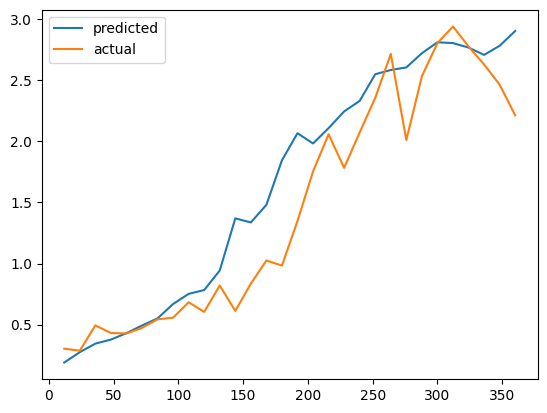

<Figure size 640x480 with 0 Axes>

In [463]:
# plot mae_pred vs mae_true
x_axis = np.arange(12, 372, 12)
pyplot.plot(x_axis, mae_pred[1:], label='predicted')
pyplot.plot(x_axis,mae_true[1:], label='actual')
pyplot.legend()
pyplot.show()
#save the plots
pyplot.savefig(os.path.join(os.path.dirname(os.getcwd()), 'models', 'plots', 'univariate', 'validation', 'mae_pred_vs_mae_true.png'))